In [88]:
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
plt.rc('figure', figsize = (24,12))



### Data Collecting & Cleaning

In [89]:

# Define the instruments to download. We would like to see Apple, Microsoft and the S&P500 index.
tickers = ['AAPL', 'MSFT', '^GSPC']

# We would like all available data from 01/01/2000 until 12/31/2016.
start_date = '2009-04-02'
end_date = '2019-3-31'

# User pandas_reader.data.DataReader to load the desired data. As simple as that.
sp500 = data.DataReader('^GSPC', 'yahoo', start_date, end_date)
Nikkei225 = data.DataReader('^N225', 'yahoo', start_date, end_date)

DAX = data.DataReader('^GDAXI', 'yahoo', start_date, end_date)
HSI = data.DataReader('^HSI', 'yahoo', start_date, end_date)
IPC = data.DataReader('^MXX', 'yahoo', start_date, end_date)
FCHI = data.DataReader('^FCHI', 'yahoo', start_date, end_date)
SH = data.DataReader('000001.SS', 'yahoo', start_date, end_date)
#SH.reset_index(level=0, inplace=True)
GOLD = pd.read_excel('Gold_index.xlsx') #sheet_name = 'Sheet1')
GOLD['Change_rate'] = GOLD.iloc[:,1].pct_change()*100
GOLD.index = GOLD['date']
#Get FTSE
FTSE = pd.read_excel('FTSE.xlsx')
FTSE['Change_rate'] = FTSE['Change %']*100
FTSE[FTSE['Date'] == '2009-4-2']
FTSE = FTSE.iloc[0:2525,:]
FTSE.sort_values(by = 'Date', inplace = True)
FTSE.index = FTSE['Date']
#mut = data.DataReader('^SP500MUT', 'yahoo', start_date, end_date)
#Indices directly gotten through API. FTSE is not included
input_indices = {
    'Nikkei225' : Nikkei225,
    'DAX': DAX,
    'HSI': HSI,
    'IPC': IPC,
    'FCHI': FCHI,
    'SH': SH,
    'FTSE': FTSE

}

### Data Wrangling and Aggregation

In [90]:
def calc_change_rate(df):
    df['Change_rate'] = (df['Close'] - df['Open']) * 100 / df['Open']

In [91]:
calc_change_rate(Nikkei225)
calc_change_rate(DAX)
calc_change_rate(HSI)
calc_change_rate(IPC)
calc_change_rate(FCHI)
calc_change_rate(SH)
calc_change_rate(sp500)

In [179]:
Nikkei225 = Nikkei225.loc[:,['Change_rate']]
sp500 = sp500.loc[:,['Change_rate']]
DAX = DAX.loc[:,['Change_rate']]
HSI = HSI.loc[:,['Change_rate']]
IPC = IPC.loc[:,['Change_rate']]
FCHI = FCHI.loc[:,['Change_rate']]
SH = SH.loc[:,['Change_rate']]
FTSE = FTSE.loc[:,['Change_rate']]
GOLD = GOLD.loc[:,['Change_rate']]

result = pd.concat([Nikkei225, DAX, HSI, IPC, FCHI, SH, FTSE, GOLD, sp500], axis=1, sort=False,join_axes=[sp500.index])
result.columns = ['Nikkei225_Change_rate','DAX_Change_rate','HSI_Change_rate','IPC_Change_rate','FCHI_Change_rate','SH_Change_rate','FTSE_Change_rate','GOLD_Change_rate','sp500_Change_rate']

In [181]:
result['sp500_yes'] = 0
result['sp500_yes'][1:] = result['sp500_Change_rate'][0:len(result['sp500_Change_rate'])-1]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [183]:
result_no_na = result.dropna()

### Visualize data distribution

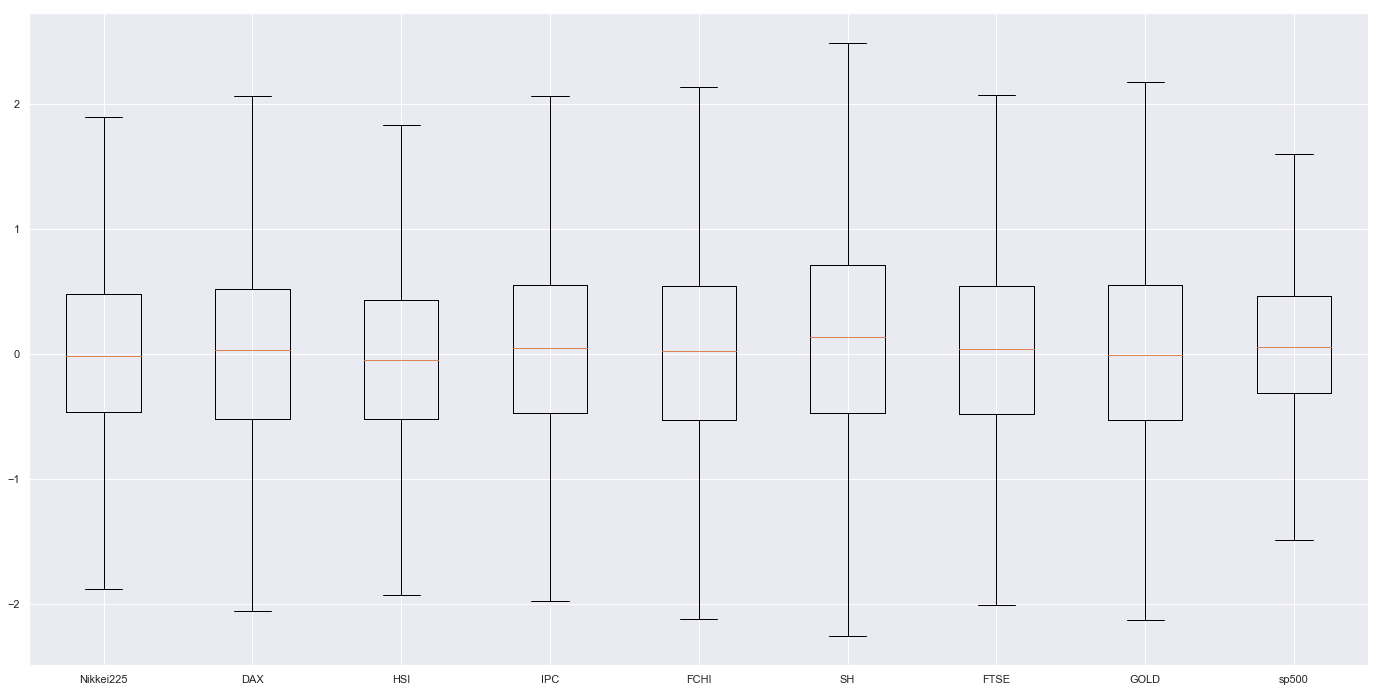

In [94]:
plot_dict = {'Nikkei225': result_no_na['Nikkei225_Change_rate'], 'DAX': result_no_na['DAX_Change_rate'], 'HSI': result_no_na['HSI_Change_rate'], 
             'IPC': result_no_na['IPC_Change_rate'], 'FCHI': result_no_na['FCHI_Change_rate'], 'SH': result_no_na['SH_Change_rate'], 
             'FTSE': result_no_na['FTSE_Change_rate'], 'GOLD': result_no_na['GOLD_Change_rate'], 'sp500': result_no_na['sp500_Change_rate']}
fig, ax = plt.subplots()
ax.boxplot(plot_dict.values(), showfliers=False)
ax.set_xticklabels(plot_dict.keys())
plt.show()

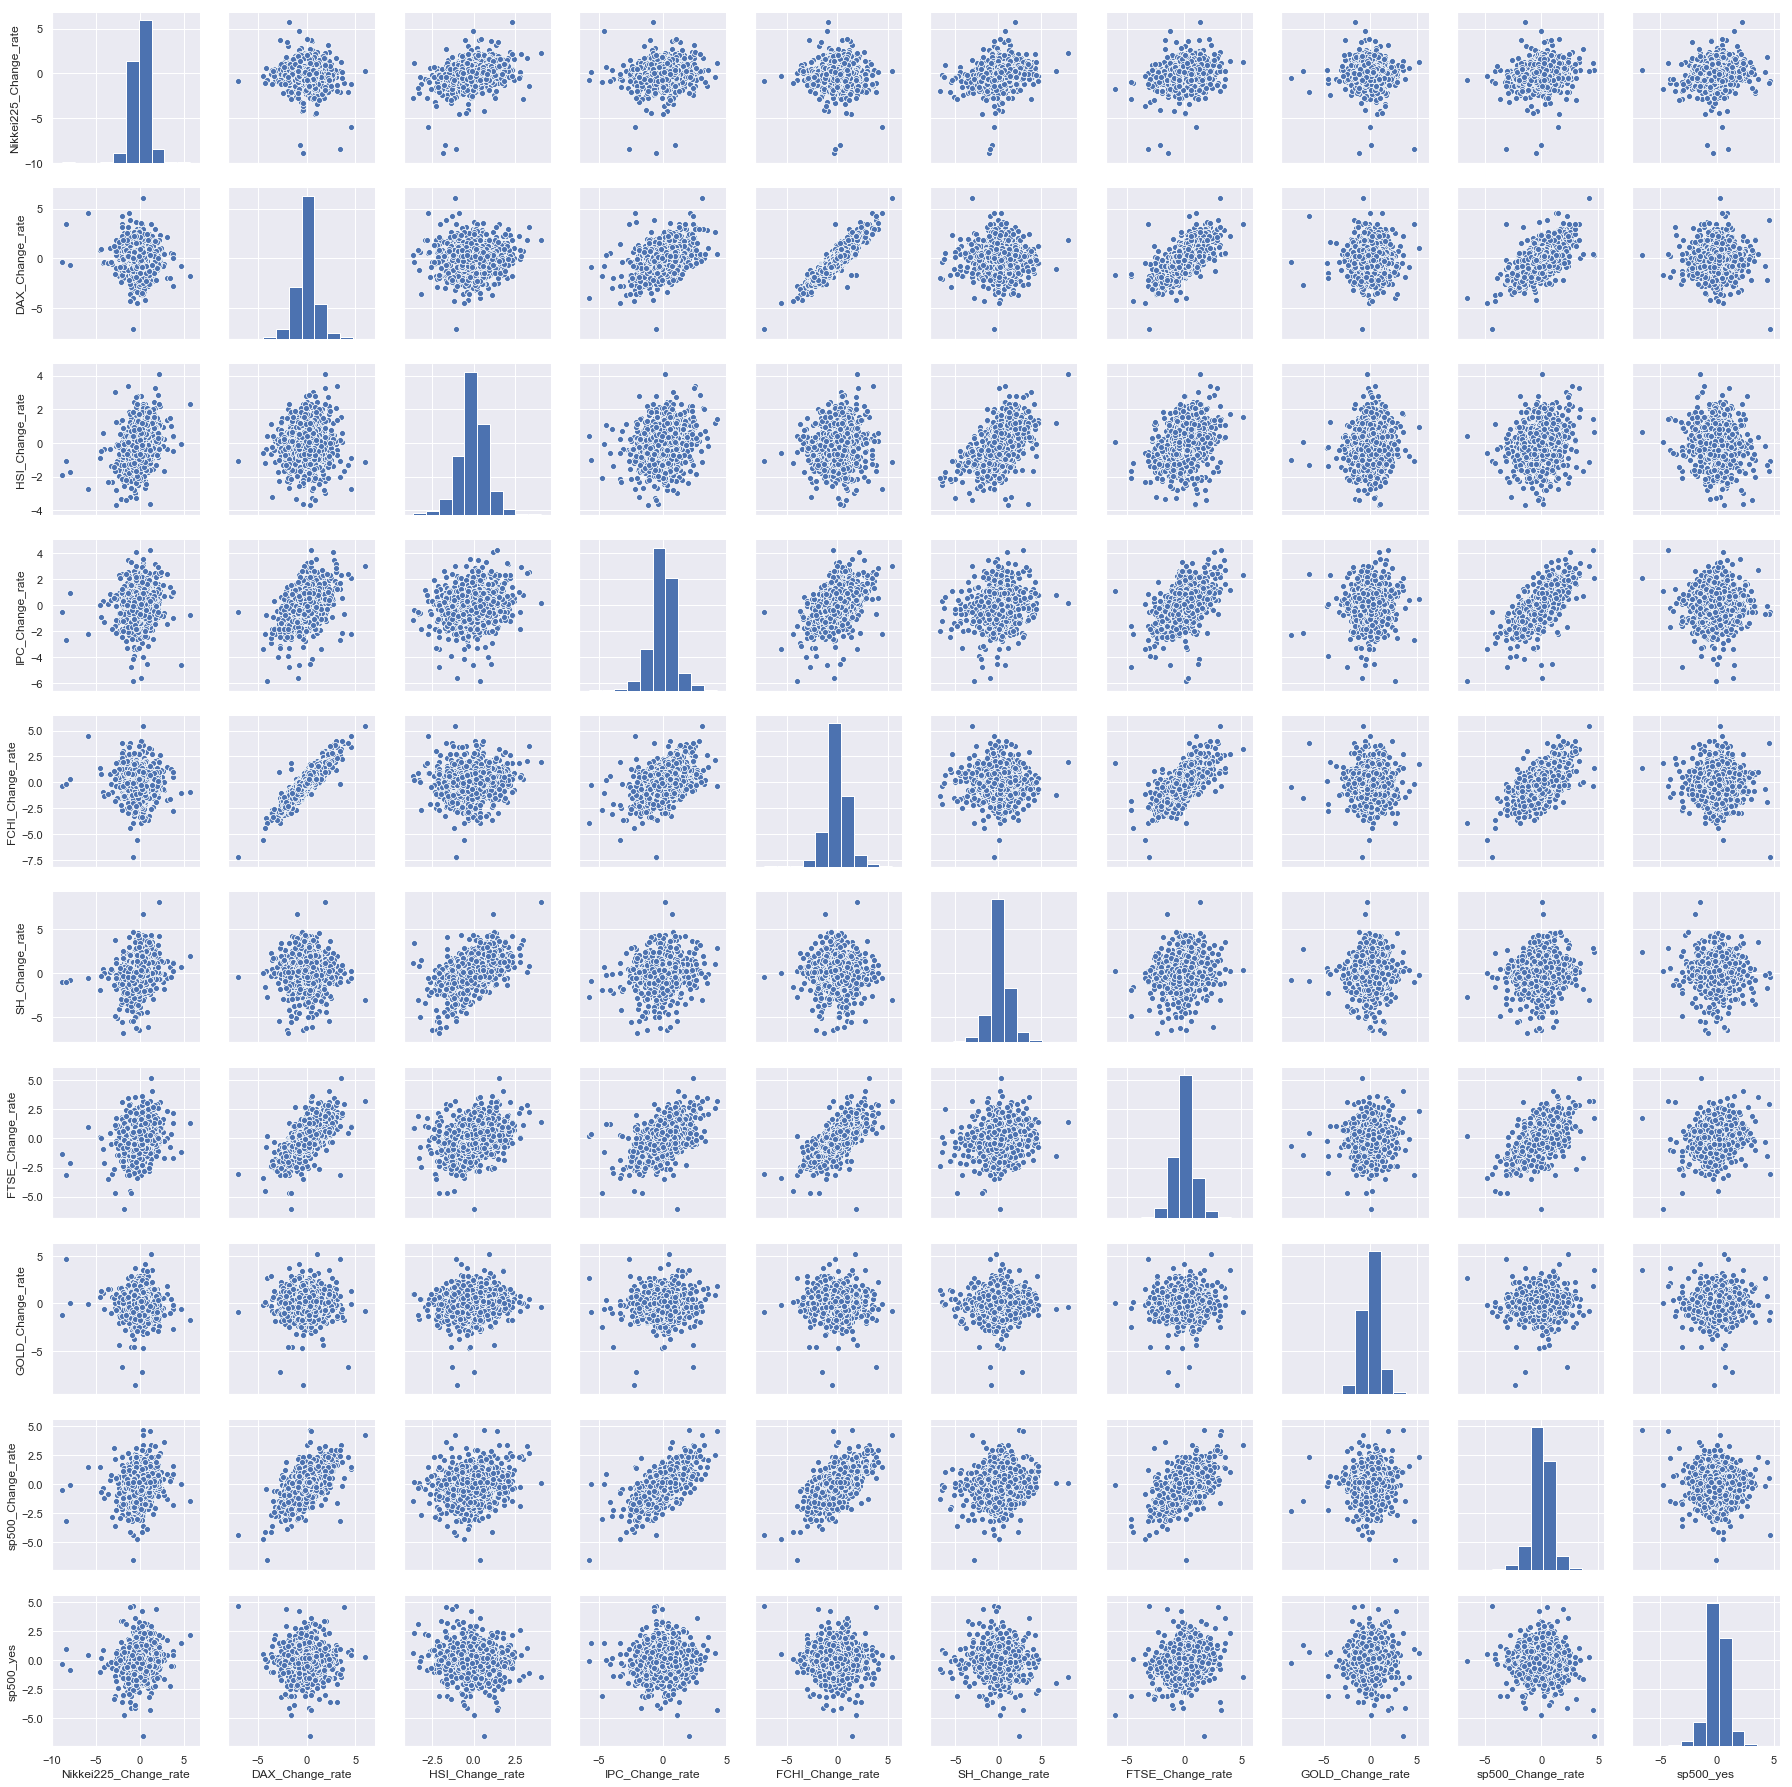

In [184]:
import seaborn as sns;sns.set()
sns.pairplot(result_no_na).to
plt.show()

In [96]:
covariance = result_no_na.cov()
covariance['sp500_Change_rate']        

Nikkei225_Change_rate    0.132487
DAX_Change_rate          0.534044
HSI_Change_rate          0.138356
IPC_Change_rate          0.537060
FCHI_Change_rate         0.559143
SH_Change_rate           0.128777
FTSE_Change_rate         0.469793
GOLD_Change_rate         0.020643
sp500_Change_rate        0.821805
Name: sp500_Change_rate, dtype: float64

In [185]:
# correlation with outliers
corr = result_no_na.corr()
corr.style.background_gradient()

,Nikkei225_Change_rate,DAX_Change_rate,HSI_Change_rate,IPC_Change_rate,FCHI_Change_rate,SH_Change_rate,FTSE_Change_rate,GOLD_Change_rate,sp500_Change_rate,sp500_yes
Nikkei225_Change_rate,1,-0.0435229,0.303722,0.130623,-0.00921473,0.216369,0.237912,-0.0214469,0.153432,0.0976454
DAX_Change_rate,-0.0435229,1,0.0846198,0.429932,0.905562,-0.0108492,0.647195,-0.0158573,0.563283,0.01233
HSI_Change_rate,0.303722,0.0846198,1,0.229046,0.0893711,0.503924,0.29039,0.0946496,0.18141,-0.0938843
IPC_Change_rate,0.130623,0.429932,0.229046,1,0.443518,0.144359,0.481449,0.0517253,0.62224,0.0407187
FCHI_Change_rate,-0.00921473,0.905562,0.0893711,0.443518,1,-0.0156053,0.679341,-0.0282788,0.590746,-0.0100529
SH_Change_rate,0.216369,-0.0108492,0.503924,0.144359,-0.0156053,1,0.160149,0.0498438,0.111765,-0.0154534
FTSE_Change_rate,0.237912,0.647195,0.29039,0.481449,0.679341,0.160149,1,0.0370395,0.542268,0.206294
GOLD_Change_rate,-0.0214469,-0.0158573,0.0946496,0.0517253,-0.0282788,0.0498438,0.0370395,1,0.023317,0.0160455
sp500_Change_rate,0.153432,0.563283,0.18141,0.62224,0.590746,0.111765,0.542268,0.023317,1,-0.0617324
sp500_yes,0.0976454,0.01233,-0.0938843,0.0407187,-0.0100529,-0.0154534,0.206294,0.0160455,-0.0617324,1


In [188]:
corr.style.background_gradient().to_excel('corr.xlsx')

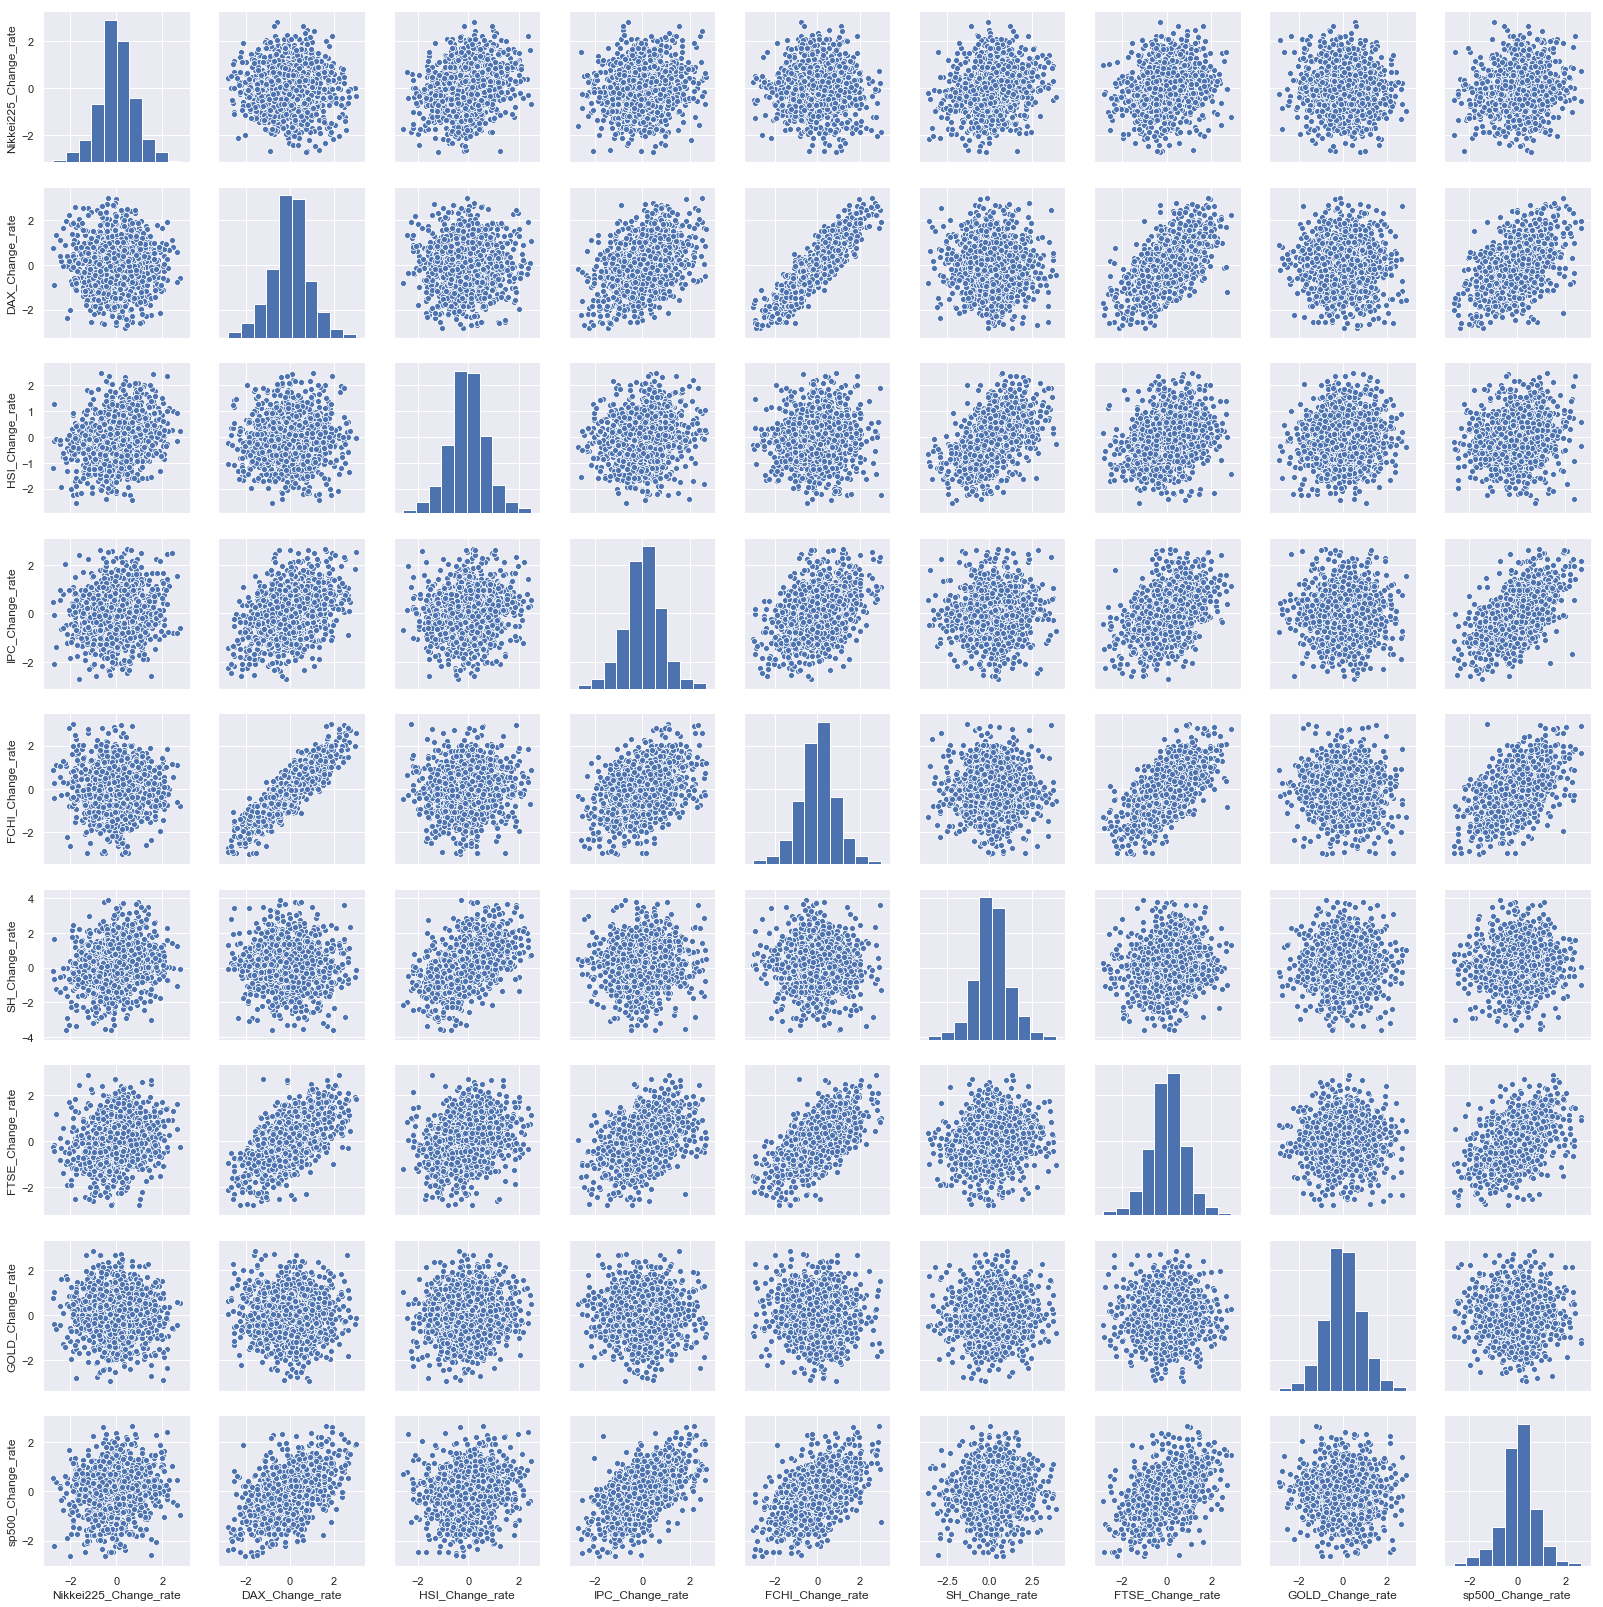

In [11]:
# outliers removed
import numpy as np
df1 = result_no_na[result_no_na.apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis=1)]
sns.pairplot(df1)
plt.show()

In [12]:
# Correlation without outliers
corr_1 = df1.corr()
corr_1.style.background_gradient()

,Nikkei225_Change_rate,DAX_Change_rate,HSI_Change_rate,IPC_Change_rate,FCHI_Change_rate,SH_Change_rate,FTSE_Change_rate,GOLD_Change_rate,sp500_Change_rate
Nikkei225_Change_rate,1,-0.0269759,0.254965,0.116887,0.0017629,0.190762,0.202813,-0.0367127,0.131549
DAX_Change_rate,-0.0269759,1,0.059093,0.367634,0.889092,-0.030248,0.60892,-0.0474661,0.484461
HSI_Change_rate,0.254965,0.059093,1,0.179294,0.0753435,0.471452,0.247727,0.0794378,0.135237
IPC_Change_rate,0.116887,0.367634,0.179294,1,0.383286,0.083279,0.418882,0.0031446,0.542607
FCHI_Change_rate,0.0017629,0.889092,0.0753435,0.383286,1,-0.0266547,0.652571,-0.0652568,0.519662
SH_Change_rate,0.190762,-0.030248,0.471452,0.083279,-0.0266547,1,0.132289,0.0470761,0.0538545
FTSE_Change_rate,0.202813,0.60892,0.247727,0.418882,0.652571,0.132289,1,0.00149202,0.464876
GOLD_Change_rate,-0.0367127,-0.0474661,0.0794378,0.0031446,-0.0652568,0.0470761,0.00149202,1,-0.0168219
sp500_Change_rate,0.131549,0.484461,0.135237,0.542607,0.519662,0.0538545,0.464876,-0.0168219,1


In [189]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters = 3, init = 'random').fit(result_no_na[['DAX_Change_rate', 'IPC_Change_rate', 'FCHI_Change_rate', 'FTSE_Change_rate', 'sp500_Change_rate']])
result_no_na['sp500_label'] = km.labels_

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


### Add Binary Label

In [190]:
# create label for classification
result_no_na['sp500_label'] = result_no_na['sp500_Change_rate']
result_no_na['sp500_label'][result_no_na['sp500_Change_rate'] < 0]     = 0
result_no_na['sp500_label'][result_no_na['sp500_Change_rate'] >= 0]    = 1

result_no_na

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:7626: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3267: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


,Nikkei225_Change_rate,DAX_Change_rate,HSI_Change_rate,IPC_Change_rate,FCHI_Change_rate,SH_Change_rate,FTSE_Change_rate,GOLD_Change_rate,sp500_Change_rate,sp500_yes,sp500_label
Date,,,,,,,,,,,
2009-04-03,-0.729056,0.724258,-0.012573,1.805169,-0.475303,-1.077049,-2.31,-1.448483,0.882497,2.436985,1.0
2009-04-07,-0.065740,-0.842124,0.046105,-0.845507,-1.152861,0.705247,-1.58,-0.028425,-2.226299,-0.508487,0.0
2009-04-08,-1.734599,1.666866,-1.636618,-0.473277,2.305955,-3.394980,-0.13,0.909866,1.028449,-2.226299,1.0
2009-04-14,-1.264202,1.514579,1.816873,0.378820,0.192690,0.603974,0.13,1.272984,-1.794884,0.397503,0.0
2009-04-15,-0.395546,0.488771,2.118208,-0.267841,0.741285,0.853612,-0.52,-0.307263,1.503383,-1.794884,1.0
2009-04-16,-1.052954,0.855956,-2.171097,1.509934,1.040275,-0.322613,2.13,-0.364248,1.259158,1.503383,1.0
2009-04-17,0.601401,1.180371,-2.225998,0.205688,1.420964,-0.819564,0.98,-1.912261,0.510874,1.259158,1.0
2009-04-20,0.282711,-3.641449,1.133853,-2.905484,-3.626893,2.291160,-2.49,-0.229358,-4.132356,0.510874,0.0
2009-04-21,-1.031116,0.289621,1.462271,-1.685579,0.335694,0.498003,-0.09,2.155172,2.265265,-4.132356,1.0


In [191]:
# stratified sampling
from sklearn.model_selection import train_test_split
X = result_no_na[['DAX_Change_rate', 'IPC_Change_rate', 'FCHI_Change_rate', 'FTSE_Change_rate']].values
y = result_no_na[['sp500_label']].values.ravel()
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train, X_vt, y_train, y_vt = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_vt, y_vt, test_size=0.5, random_state=42, stratify=y_vt)

In [192]:
y_train

array([1., 1., 0., ..., 1., 0., 0.])

### Training and Applying Models

In [193]:
# knn classifer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
knn = KNeighborsClassifier()
k_range = range(1, 21)
weight_options = ['uniform', 'distance']
param_grid = dict(n_neighbors=k_range, weights=weight_options)
grid = GridSearchCV(knn, param_grid, cv=10, scoring='f1_weighted', return_train_score=True)
grid.fit(X_train, y_train)
print('Best score: '+str(grid.best_score_))
print('Best params: '+str(grid.best_params_))
clf_1 = KNeighborsClassifier(n_neighbors=grid.best_params_['n_neighbors'], weights=grid.best_params_['weights'])
clf_1.fit(X_train, y_train)
knn_accuracy = clf_1.score(X_val,y_val)
print('knn accuracy: '+ str(knn_accuracy))

Best score: 0.7008836031134051
Best params: {'n_neighbors': 12, 'weights': 'distance'}
knn accuracy: 0.7092651757188498


In [194]:
res = pd.DataFrame({'pred': clf_1.predict(X_val)})
res['real'] = y_val
(res['pred'] == res['real']).sum() / len(y_val)

0.7092651757188498

In [202]:
# random forest find para
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
random_grid = {'max_depth': range(10,100,10),
               'max_features': ['auto', 'sqrt'],
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'n_estimators': range(10,510,20)}
rf = RandomForestClassifier(random_state = 42)
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter = 100, cv = 5)

rf_random.fit(X_train, y_train)
rf_random.best_params_

{'n_estimators': 490,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 50}

In [ ]:
# random forest classification
clf_3 = RandomForestClassifier(n_estimators = rf_random.best_params_['n_estimators'],
                             min_samples_split = rf_random.best_params_['min_samples_split'],
                             min_samples_leaf = rf_random.best_params_['min_samples_leaf'],
                             max_features = rf_random.best_params_['max_features'],
                             max_depth = rf_random.best_params_['max_depth']
                            )
clf_3.fit(X_train, y_train)
accuracy = clf_3.score(X_val, y_val)
print('resulting accuracy rate: '+str(accuracy))

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np
#Gradientboosting classifier
learning_rate = [1, 0.5, 0.25, 0.1, 0.05, 0.01]
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)] # Maximum number of levels in tree
max_depth.append(None)
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 100, num = 10)] # Number of trees in random forest
max_features = ['auto', 'sqrt'] # Number of features to consider at every split
min_samples_split = [2, 5, 10] # Minimum number of samples required to split a node
min_samples_leaf = [1, 2, 4] # Minimum number of samples required at each leaf node

param = {'learning_rate': learning_rate,
         'n_estimators': n_estimators,
         'max_features': max_features,
         'max_depth': max_depth,
         'min_samples_split': min_samples_split,
         'min_samples_leaf': min_samples_leaf}

gb = GradientBoostingClassifier(random_state=42)
random_gb = RandomizedSearchCV(estimator = gb, param_distributions = param, n_iter = 10, cv = 5, random_state=42, iid=True)
random_gb.fit(X_train, y_train)
random_gb.best_params_

clf_6 = GradientBoostingClassifier(learning_rate=random_gb.best_params_['learning_rate'],
                                      n_estimators=random_gb.best_params_['n_estimators'],
                                      min_samples_split=random_gb.best_params_['min_samples_split'],
                                      min_samples_leaf=random_gb.best_params_['min_samples_leaf'],
                                      max_features=random_gb.best_params_['max_features'],
                                      max_depth=random_gb.best_params_['max_depth'],
                                      random_state=42)
clf_6.fit(X_train, y_train)
accuracy = clf_6.score(X_val, y_val)
print('Accuracy rate is :',accuracy)

In [ ]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(solver='liblinear').fit(X_train, y_train)
clf.score(X_val, y_val)

In [ ]:
#SVC. Find best parameter for SVC
from sklearn.svm import SVC
svc = SVC(gamma='auto')
random_grid = {'decision_function_shape': ['ovo', 'ovr'],
               'C': [1, 0.1, 5],
               'degree': [3,4],
               'shrinking': [True, False],
               'tol': [0.001, 0.01, 0.0001],
              }
svc_rd = RandomizedSearchCV(estimator=svc, param_distributions=random_grid, n_iter = 100, cv = 5)
svc_rd.fit(X_train, y_train)

clf7 = SVC(tol = svc_rd.best_params_['tol'],
       shrinking = svc_rd.best_params_['shrinking'],
       degree = svc_rd.best_params_['degree'],
       decision_function_shape = svc_rd.best_params_['decision_function_shape'],
       C = svc_rd.best_params_['C'])

In [201]:
#Use SVM model to predict
clf7.fit(X_train, y_train)
clf7.score(X_val, y_val)

/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.7060702875399361

In [ ]:
#Find best parameter for neural network
random_grid_mlp = {'hidden_layer_sizes': range(10,200,30),
               'activation': ['identity', 'logistic', 'tanh', 'relu'],
               'solver': ['lbfgs', 'sgd', 'adam'],
               'alpha': [0.0001, 0.00001, 0.001],
               'learning_rate': ['constant', 'invscaling', 'adaptive'],
               'tol': [0.0001, 0.000001, 0.001]}
MLP = MLPClassifier(random_state = 42)
grid = GridSearchCV(MLP, random_grid_mlp, cv=10, scoring='f1_weighted', return_train_score=True)
grid.fit(X_train, y_train)
#NNW.score(X_val, y_val)

###best parameter for NNW
activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=40, learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=42, shuffle=True, solver='sgd', tol=1e-06,
       validation_fraction=0.1, verbose=False, warm_start=False

In [200]:
#Apply neural network model
NNW_best = MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=40, learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=42, shuffle=True, solver='sgd', tol=1e-06,
       validation_fraction=0.1, verbose=False, warm_start=False)

NNW_best.fit(X_train, y_train)
NNW_best.score(X_val, y_val)

/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.7188498402555911

### Train and apply blending ensemble model

In [211]:
X_val[1]

array([1.07552359, 1.41044685, 0.52672588, 0.21      ])

In [214]:
X_test = [[0.25, -0.73, 0.66, -0.05]]
test_0 = clf.predict(X_test)
test_1 = clf_1.predict(X_test)
test_3 = clf_3.predict(X_test)
test_6 = clf_6.predict(X_test)
test_nnw = NNW_best.predict(X_test)
test = [test_0, test_1, test_3,test_nnw]
X_test_blend = pd.DataFrame(data = test).T
clf.predict(X_test_blend)

array([1.])

In [ ]:
X_test_blend['y_test'] = y_test

In [ ]:
#Train and apply blending ensemble model
from sklearn.linear_model import LogisticRegression
pred_0 = clf.predict(X_val)
pred_1 = clf_1.predict(X_val)
pred_3 = clf_3.predict(X_val)
pred_6 = clf_6.predict(X_val)
pred_nnw = NNW_best.predict(X_val)
pred = [pred_0, pred_1, pred_3, pred_nnw]
X_validate_blend = pd.DataFrame(data = pred).T
clf_ensemble = LogisticRegression(solver='liblinear').fit(X_validate_blend, y_val)
accuracy_0 = clf.score(X_test, y_test)
print('Logistic accuracy rate: '+str(accuracy_0))
accuracy_1 = clf_1.score(X_test, y_test)
print('knn accuracy rate: '+str(accuracy_1))
accuracy_3 = clf_3.score(X_test, y_test)
print('random forest accuracy rate: '+str(accuracy_3))
accuracy_6 = clf_6.score(X_test, y_test)
print('gradient boosting accuracy rate: '+str(accuracy_6))
accuracy_NNW = NNW_best.score(X_val, y_val)
print('Neural Network accuracy rate: '+str(accuracy_NNW))
# apply ensemble models to testing dataset
test_0 = clf.predict(X_test)
test_1 = clf_1.predict(X_test)
test_3 = clf_3.predict(X_test)
test_6 = clf_6.predict(X_test)
test_nnw = NNW_best.predict(X_test)
test = [test_0, test_1, test_3,test_nnw]
X_test_blend = pd.DataFrame(data = test).T
accuracy = clf_ensemble.score(X_test_blend, y_test)
print('ensemble models accuracy rate: '+str(accuracy))

### Train and Applying Stacking Ensemble Model

In [198]:
#Train stacking ensemble model
#stacking L1
pred_comb_0 = pd.DataFrame([pred_0, pred_1, pred_3]).T
pred_comb_1 = pd.DataFrame([pred_1, pred_3, pred_nnw]).T
pred_comb_2 = pd.DataFrame([pred_0,pred_3, pred_nnw]).T
pred_comb_3 = pd.DataFrame([pred_0, pred_1, pred_nnw]).T
#X_validate_blend = pd.DataFrame(data = ).T
clf_c0 = LogisticRegression(solver='liblinear').fit(pred_comb_0, y_val)
clf_c1 = LogisticRegression(solver='liblinear').fit(pred_comb_1, y_val)
clf_c2 = LogisticRegression(solver='liblinear').fit(pred_comb_2, y_val)
clf_c3 = LogisticRegression(solver='liblinear').fit(pred_comb_3, y_val)
l1_result_0 = clf_c0.predict(pred_comb_0)
l1_result_1 = clf_c1.predict(pred_comb_1)
l1_result_2 = clf_c2.predict(pred_comb_2)
l1_result_3 = clf_c3.predict(pred_comb_3)
l1_result_all = pd.DataFrame([l1_result_0, l1_result_1, l1_result_2, l1_result_3]).T
from sklearn.svm import SVC
svc = SVC(gamma='auto')
random_grid = {'decision_function_shape': ['ovo', 'ovr'],
               'C': [1, 0.1, 5],
               'degree': [3,4],
               'shrinking': [True, False],
               'tol': [0.001, 0.01, 0.0001],
              }
svc_random = RandomizedSearchCV(estimator=svc, param_distributions=random_grid, n_iter = 100, cv = 5)

In [197]:
#find best parameter for SVM
svc_random.best_params_
svc_best = SVC(tol = svc_random.best_params_['tol'],
               shrinking = svc_random.best_params_['shrinking'],
               degree = svc_random.best_params_['degree'],
               decision_function_shape = svc_random.best_params_['decision_function_shape'],
               C = svc_random.best_params_['C'])
svc_best.fit(l1_result_all, y_val)

/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovo', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [196]:
#stacking result
pred_t_comb_0 = pd.DataFrame([test_0, test_1, test_3]).T
pred_t_comb_1 = pd.DataFrame([test_1, test_3, test_nnw]).T
pred_t_comb_2 = pd.DataFrame([test_0, test_3, test_nnw]).T
pred_t_comb_3 = pd.DataFrame([test_0, test_1, test_nnw]).T
l1_t_result_0 = clf_c0.predict(pred_t_comb_0)
l1_t_result_1 = clf_c1.predict(pred_t_comb_1)
l1_t_result_2 = clf_c2.predict(pred_t_comb_2)
l1_t_result_3 = clf_c3.predict(pred_t_comb_3)
l1_t_result_all = pd.DataFrame([l1_t_result_0, l1_t_result_1, l1_t_result_2, l1_t_result_3]).T
svc_best.score(l1_t_result_all, y_test)

0.7420382165605095

In [206]:
from sklearn.metrics import r2_score
r2_score(y_test, svc_best.predict(l1_t_result_all))

-0.04135276776940722

In [205]:
svc_best.predict(l1_t_result_all) == y_test

array([ True, False, False,  True, False,  True,  True,  True, False,
       False,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True, False,  True, False,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True, False, False,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True, False, False,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True, False, False,
       False, False,  True,  True,  True,  True, False, False, False,
        True, False, False,  True, False,  True, False,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True, False,  True,  True,  True,  True,
       False,  True,